<center><h1>CORONA VIRUS PREDICTION<h1></center>

![CORONA VIRUS PREDICTION](corona.jpg)


In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import datetime
from datetime import date, timedelta
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


<h3>Reading Dataset<h3>

In [2]:
df = pd.read_csv('dataset.csv', index_col = 'Date')
df_india = df[df['Country/Region'] == 'India'].copy()

In [3]:
df_india.head()

,Province/State,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
Date,,,,,,,
1/22/20,NaN,India,21.0,78.0,0,0,0
1/23/20,NaN,India,21.0,78.0,0,0,0
1/24/20,NaN,India,21.0,78.0,0,0,0
1/25/20,NaN,India,21.0,78.0,0,0,0
1/26/20,NaN,India,21.0,78.0,0,0,0


In [4]:
df_india.shape

(76, 7)

<h3>Check NULL Values<h3>

In [5]:
df_india.isna().sum()

Province/State    76
Country/Region     0
Lat                0
Long               0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

<h3>Graphical Representation of Cases in India<h3>

In [6]:
corona_cases = df_india
py.init_notebook_mode(connected=True)

data = corona_cases.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.strftime('%m/%d/%Y')
data['Active'] = data['Confirmed'] - data['Recovered'] - data['Deaths']
data['Country'] =  data['Country/Region']

fig = px.choropleth(data, locations="Country", locationmode='country names', 
                     color="Confirmed", hover_name="Country/Region",hover_data = [data.Recovered,data.Deaths,data.Active],projection="mercator",
                     animation_frame="Date",width=1000, height=700,
                     color_continuous_scale='Reds',
                     title='Map of Coronavirus')

fig.update(layout_coloraxis_showscale=True)
py.offline.iplot(fig)

In [7]:
ind_map  = df_india.groupby(['Date', 'Country/Region','Lat','Long'])['Confirmed', 'Deaths', 'Recovered'].max()


ind_map = ind_map.reset_index()
ind_map.head()
ind_map['size'] = ind_map['Confirmed']*90000000
ind_map
fig = px.scatter_mapbox(ind_map, lat="Lat", lon="Long",
                     color="Confirmed", size='size',hover_data=['Confirmed','Recovered','Deaths'],
                     color_continuous_scale='burgyl',
                     animation_frame="Date", 
                     title='Spread total cases over time')
fig.update(layout_coloraxis_showscale=True)
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=3)
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

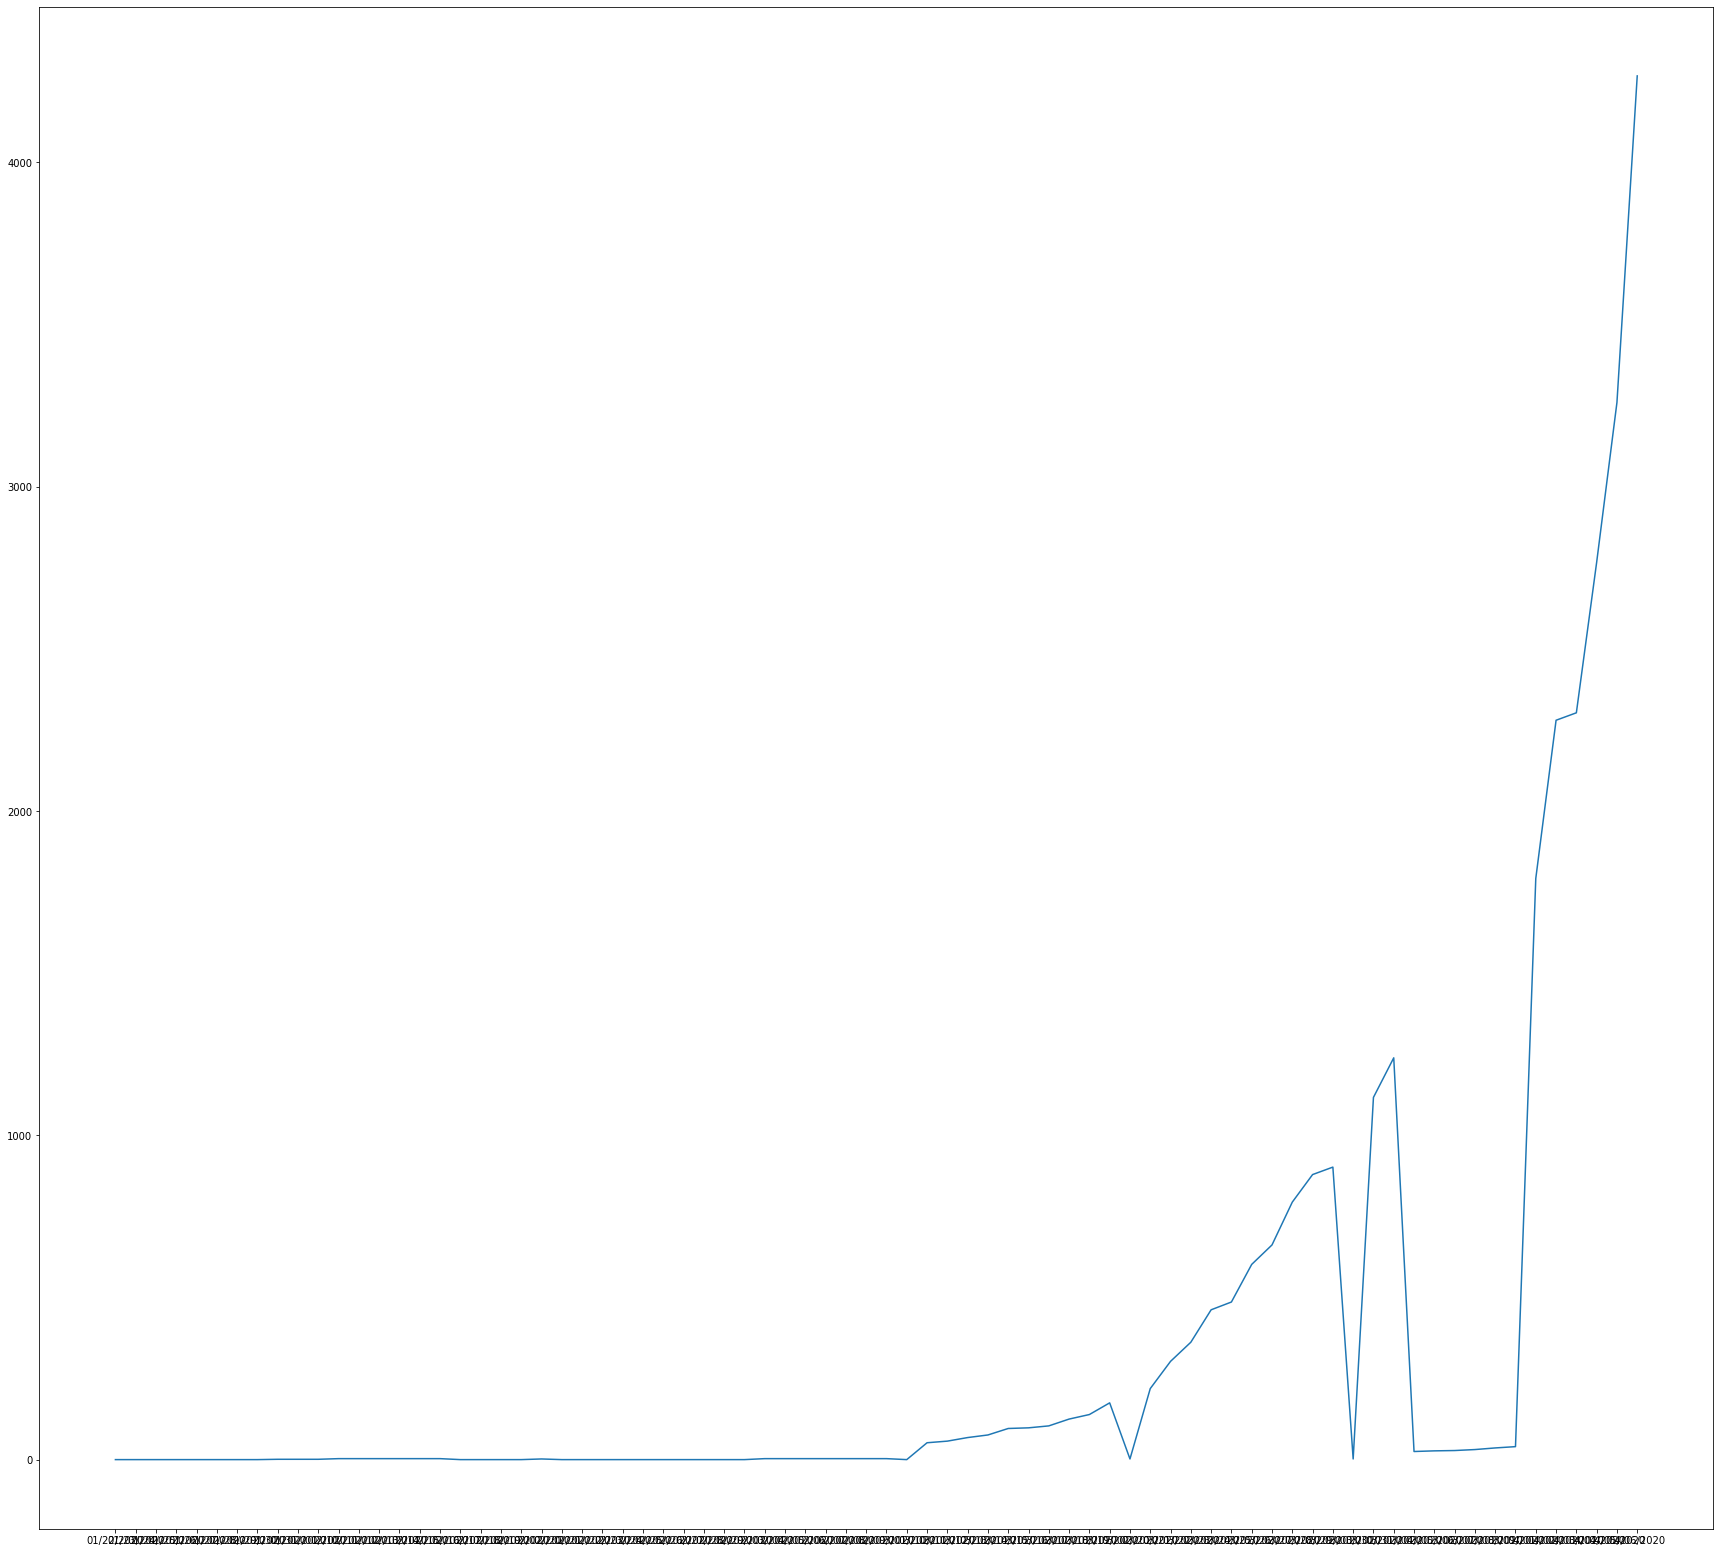

In [8]:
plt.figure(figsize = (30,28))
plt.plot(data['Date'], data['Active'])

<h3>Confirmed Cases Prediction<h3>

In [9]:
pred_cnfrm = df_india.loc[:,["Confirmed"]]

In [10]:
train_data = pred_cnfrm[:len(pred_cnfrm)-3]
test_data = pred_cnfrm[len(pred_cnfrm)-3:]

In [11]:
train_data

,Confirmed
Date,
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0
...,...
3/30/20,1251
3/31/20,1397
4/1/20,1998


In [12]:
test_data

,Confirmed
Date,
4/4/20,3082
4/5/20,3588
4/6/20,4778


In [13]:
early_stop = EarlyStopping(patience = 1, monitor = "val_loss")

scaler = MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [14]:
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
scaled_full_data = scaler.transform(pred_cnfrm)

In [15]:
n_input = 2
n_features = 1
                             
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data, length=n_input, batch_size=1)

val_generator = TimeseriesGenerator(scaled_test_data,scaled_test_data, length=n_input, batch_size=1)

In [21]:
lstm_model = Sequential()

lstm_model.add(SimpleRNN(units = 22, input_shape = (n_input, n_features), return_sequences=True, activation = 'relu'))
# lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units = 22, input_shape = (n_input, n_features), activation = 'relu'))
# lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units = 1))


lstm_model.compile(optimizer = 'adam', loss = 'mse')

lstm_model.fit(generator, epochs = 200,
              validation_data = val_generator,
              callbacks = [early_stop])

Epoch 1/200
71/71 [==============================] - 1s 17ms/step - loss: 0.0468 - val_loss: 2.6488
Epoch 2/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0309 - val_loss: 1.7444
Epoch 3/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.2636
Epoch 4/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0102
Epoch 5/200
71/71 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0135


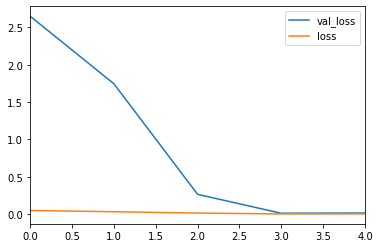

In [22]:
pd.DataFrame(lstm_model.history.history).plot()

In [23]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

confirmed_prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
confirmed_prediction

,0
0,3332.037244
1,3753.201594
2,4878.593750


<h3>Deaths Predictions<h3>

In [24]:
pred_cnfrm_deaths = df_india.loc[:,["Deaths"]]

In [31]:
train_data_deaths = pred_cnfrm_deaths[:len(pred_cnfrm)-3]
test_data_deaths = pred_cnfrm_deaths[len(pred_cnfrm)-3:]

In [32]:
early_stop = EarlyStopping(patience = 2, monitor = "val_loss")

scaler = MinMaxScaler()
scaler.fit(train_data_deaths)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [33]:
scaled_train_data_deaths = scaler.transform(train_data_deaths)
scaled_test_data_deaths = scaler.transform(test_data_deaths)
scaled_full_data_deaths = scaler.transform(pred_cnfrm_deaths)

In [34]:
n_input = 2
n_features = 1
                             
generator = TimeseriesGenerator(scaled_train_data_deaths, scaled_train_data_deaths, length=n_input, batch_size=1)

val_generator = TimeseriesGenerator(scaled_test_data_deaths, scaled_test_data_deaths, length=n_input, batch_size=1)

In [39]:
lstm_model = Sequential()

lstm_model.add(SimpleRNN(units = 22, input_shape = (n_input, n_features), return_sequences=True, activation = 'relu'))
# lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units = 22, input_shape = (n_input, n_features), activation = 'relu'))
# lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units = 1))


lstm_model.compile(optimizer = 'adam', loss = 'mse')

lstm_model.fit(generator, epochs = 20,
              validation_data = val_generator,
              callbacks = [early_stop])

Epoch 1/20
71/71 [==============================] - 1s 17ms/step - loss: 0.0443 - val_loss: 2.9111
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0311 - val_loss: 2.2803
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0181 - val_loss: 0.9565
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.1744
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0545
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.1925
Epoch 7/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0838


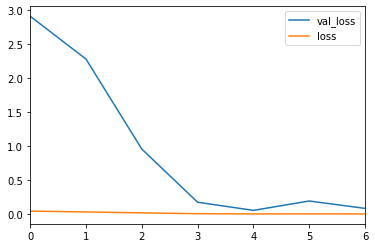

In [40]:
pd.DataFrame(lstm_model.history.history).plot()

In [41]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

deaths_prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
deaths_prediction

,0
0,89.334237
1,97.436577
2,117.715176


<h3>Total Recovered Patients Predictions<h3>

In [42]:
pred_cnfrm_recovered = df_india.loc[:,["Recovered"]]

In [43]:
train_data_recovered = pred_cnfrm_recovered[:len(pred_cnfrm_recovered)-3]
test_data_recovered = pred_cnfrm_recovered[len(pred_cnfrm_recovered)-3:]

In [44]:
early_stop = EarlyStopping(patience = 2, monitor = "val_loss")

scaler = MinMaxScaler()
scaler.fit(train_data_recovered)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [45]:
scaled_train_data_recovered = scaler.transform(train_data_recovered)
scaled_test_data_recovered = scaler.transform(test_data_recovered)
scaled_full_data_recovered = scaler.transform(pred_cnfrm_recovered)

In [54]:
n_input = 2
n_features = 1
                             
generator = TimeseriesGenerator(scaled_train_data_recovered, scaled_train_data_recovered, length=n_input, batch_size=1)

val_generator = TimeseriesGenerator(scaled_test_data_recovered,scaled_test_data_recovered, length=n_input, batch_size=1)

In [55]:
lstm_model = Sequential()

lstm_model.add(SimpleRNN(units = 22, input_shape = (n_input, n_features), return_sequences=True, activation = 'relu'))
# lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units = 22, input_shape = (n_input, n_features), activation = 'relu'))
# lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units = 1))


lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

lstm_model.fit(generator, epochs = 20,
              validation_data = val_generator,
              callbacks = [early_stop])

Epoch 1/20
71/71 [==============================] - 1s 17ms/step - loss: 0.0534 - val_loss: 3.3087
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0401 - val_loss: 2.6098
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0263 - val_loss: 1.4034
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0084 - val_loss: 0.2461
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0942
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 9.9005e-04 - val_loss: 0.1452
Epoch 7/20
71/71 [==============================] - 0s 5ms/step - loss: 9.8358e-04 - val_loss: 0.0954


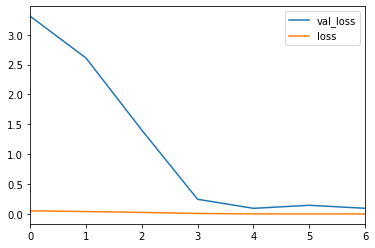

In [56]:
pd.DataFrame(lstm_model.history.history).plot()

In [57]:
lstm_predictions_scaled = []

batch = scaled_train_data_recovered[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(scaled_test_data_recovered)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

recovered_prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
forecast_recovered_prediction = scaler.inverse_transform(lstm_predictions_scaled)
recovered_prediction    

,0
0,255.039070
1,286.695580
2,376.895988
